# Lecture 3: Deutsch-Josza algorithm

<center><img src="./figures/dall-e/merlion_dj.png" alt="drawing" width="400"/></center>
<center><strong>Fig. 3:</strong> The merlion cheking if a target is balanced [DALL-E].</center>


## Introduction

One of the first algorithms in which quantum computing has been proven to be more effective than classical computing is the Deutsch-Josza algorithm. 

The goal of this algorithm is to understand if a target function $f$ is constant or balanced.
<center><img src="./figures/dj.svg" alt="drawing" width="800"/></center>
Since we want to use the quantum computing to tackle the problem, we use to formalize it in the following way.

1. let's consider a function $f$ which takes as input a bitstring $x$ and returns one single value between zero and one: $$ f(x): \{0,1\}^N \to \{0,1\};$$
2. we define it constant if $f(x)=0$ or $f(x)=1$ independently of the bitstring $x$;
3. on the other hand, we define it balanced if it returns half of the time zero and half of the time one.

#### The main ingredients of DJ algorithm

We are going to implement the DJ algorithm considering $N$-long input bitstrings. To do this, we need to initialize an $N+1$ qubits circuit, in which the first $N$ qubits (also called **input register**) are used to encode the bitstring, while the last qubit is used as ancilla. 

We denote the input register state with $|x\rangle$ and the ancilla state with $|y\rangle$.
<center><img src="./figures/dj-circ.png" alt="drawing" width="500"/></center>

At this point, we apply the following steps:
1. we prepare the **input register** in the $|0\rangle^{\otimes N}$ and the ancilla into the $|1\rangle$;
2. we apply an Hadamard gate to each qubit of the system, so that we create a maximally superposed state;
3. we apply an **oracle** operation, which has to be implemented so that it represents our input string. At this stage, we can see the oracle as a black-box whose action on the system is: $$ |x\rangle |y\rangle \to |x\rangle |y \oplus f(x)\rangle,$$ but we are going to open the black-box later in the lecture.
4. we apply again an Hadamard gate to each qubit of the **input register**;
5. we measure the state of the **input register**.
6. if the first $N$ qubits are in the $|0\rangle^{\otimes N}$, the function $f$ is detected as constant, otherwise it is detected as balanced.

#### Some useful imports

In [1]:
# import qibo and its objects
import qibo
from qibo import Circuit, gates

# import useful plotscripts
# plot_input_register_amplitudes 
from scripts.plotscripts import plot_input_register_amplitudes

# set the backend
qibo.set_backend("qibojit")

[Qibo 0.2.4|INFO|2024-01-29 17:42:47]: Using qibojit (numba) backend on /CPU:0


#### Start building DJ algorithm

As first step we can build the DJ algorithm parts which are well defined independently from the oracle function.

In [2]:
# set the number of qubits (for example 3)
nqubits = 3

In [3]:
# we will build the whole circuit as sum of: state preparation + oracle + final hadamards and measurements

# initial layer 
def build_initial_layer(n):
    """Build Deutsch-Josza superposition layer."""
    # n+1 qubits circuit 
    c = Circuit(n+1)
    # prepare |0>|0> ... |1> and then superposition
    c.add(gates.X(n))
    for q in range(n+1):
        c.add(gates.H(q=q))
    return c

# final layer
def build_final_layer(n):
    """Final layer of the Deutsch-Josza circuit."""
    # n+1 qubits circuit
    c = Circuit(n+1)
    # superposition for the input register
    for q in range(n):
        c.add(gates.H(q=q))
    # measurements over the input register
    c.add(gates.M(*range(n)))
    return c    

We can start building the DJ circuit by adding the initial layer.

In [4]:
# build the initial layer and draw the circuit
c = build_initial_layer(n=nqubits)

print(c.draw())

q0: ─H───
q1: ─H───
q2: ─H───
q3: ─X─H─


We can have a look to the amplitudes of the first $N$ qubits of the system using a plotscript you can import as `scripts.plotscripts.plot_input_register_amplitudes`. This function computes the amplitude of the first $N$ qubits of an $N+1$ system of qubits removing the dependence on the ancilla.

(0.25+0j)|0000> + (-0.25+0j)|0001> + (0.25+0j)|0010> + (-0.25+0j)|0011> + (0.25+0j)|0100> + (-0.25+0j)|0101> + (0.25+0j)|0110> + (-0.25+0j)|0111> + (0.25+0j)|1000> + (-0.25+0j)|1001> + (0.25+0j)|1010> + (-0.25+0j)|1011> + (0.25+0j)|1100> + (-0.25+0j)|1101> + (0.25+0j)|1110> + (-0.25+0j)|1111>


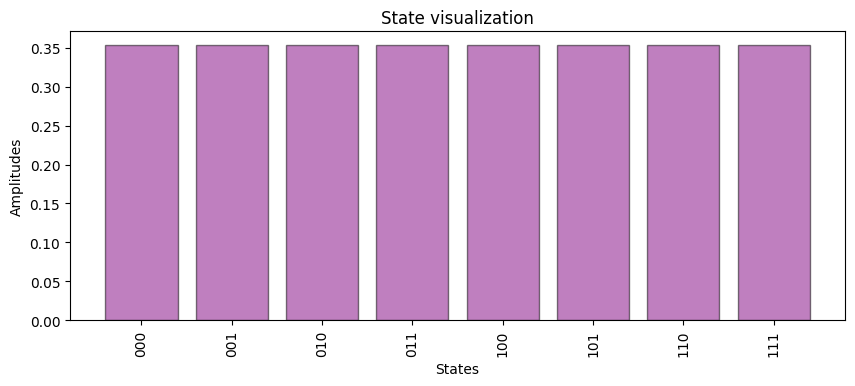

In [5]:
# to plot the amplitudes we need to save the qibo state object
outcome = c()

print(outcome)

# then we can call plot_input_register_amplitudes
plot_input_register_amplitudes(outcome.state())

As you can see from the plot, the system is in the complete superposed state we get applying the Hadamards to the state $|0\rangle^{\otimes N}$.

Let's have a look to the final layer too:

In [6]:
# build final layer circuit and draw it
c = build_final_layer(n=nqubits)

print(c.draw())

q0: ─H─M─
q1: ─H─M─
q2: ─H─M─
q3: ─────


### Opening the black box: oracle definition

We need to define into a sequence of gates a function $f$ which can be balanced or constant acting as $$ |x\rangle |y\rangle \to |x\rangle |y \oplus f(x)\rangle \\.$$ We are going to implement it as by cases.

#### Constant oracle

The easiest way to implement a function $f$ which always returns $0$ indipendently of $|x\rangle$ is to leave the system as it is, without applying any operation on the ancilla. This is equivalent to apply a function which constantly returns zero.

In [7]:
def build_constant_oracle(n):
    """Build oracle function."""
    # n+1 qubits circuit
    c = Circuit(n+1)
    return c

In [8]:
# build constant oracle and draw it
c = build_constant_oracle(nqubits)

print(c.draw())

q0: ─
q1: ─
q2: ─
q3: ─


What we expect from a constant oracle of this nature is that the initial state is untouched. This can be verified by plotting the input register's amplitudes.

In [9]:
# what do we get after initial_layer + constant_oracle?
# build circuit, draw it
c = build_initial_layer(n=nqubits) + build_constant_oracle(n=nqubits)

print(c.draw())

q0: ─H───
q1: ─H───
q2: ─H───
q3: ─X─H─


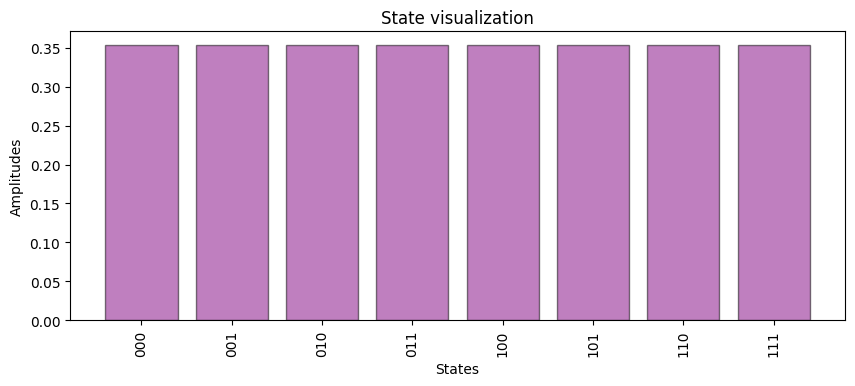

In [10]:
# collect state object and visualize state through plot_input_register_amplitudes
outcome = c()

plot_input_register_amplitudes(outcome.state())

<div style="background-color: rgba(255, 105, 105, 0.3); border: 2.5px solid #000000; padding: 15px;">
    <strong>Exercise:</strong> how to create the oracle corresponding to a constant function f(x)=1?
</div>

#### Balanced oracle

A balanced function can be implemented by applying CNOT gates using a control qubit which is in a complete superposed state. In fact, when we apply an Hadamard gate to a qubit prepared into the zero state, we get the superposed one: $$ |\psi\rangle \frac{1}{\sqrt{2}} (|0\rangle + |1\rangle),$$
and if we use it as control while applying a controlled gate, it will act as a trigger by applying the operator with an exact probability of 50%, corresponding to the state amplitude related to state $|1\rangle$.

In [11]:
def build_balanced_oracle(bitstring):
    """
    A flexible balanced oracle which acts the ancilla only with one 
    specific input bitstring.
    
    Args:
        bitstring (str): sequence of ``n`` bits.
    """
    n = len(bitstring)
    # n+1 qubits circuit
    c = Circuit(n+1)
    ones = []

    # we will use the ones position to apply some gates
    for i, bit in enumerate(bitstring):
        if bit == "1":
            ones.append(i)        

    # controlled-NOT over marked qubits
    for q in ones:
        c.add(gates.CNOT(q0=q, q1=n))
    
    return c

In [12]:
# build balanced oracle and draw it
c = build_balanced_oracle("100")
print(c.draw())
# you can set a desired string, e.g. "100"

q0: ─o─
q1: ─|─
q2: ─|─
q3: ─X─


If the balanced oracle is acting in a proper way, it should flip the amplitudes of half states of the system (the ones corresponding to the cases in which an odd number of the control qubits occupy the state $|1\rangle$). We can check it by plotting the amplitudes after applying `initial_layer + balanced_oracle`.

In [18]:
# what do we get after initial_layer + balanced_oracle?
c = build_initial_layer(n=nqubits) + build_balanced_oracle("101")

# build circuit, draw it
print(c.draw())

q0: ─H───o───
q1: ─H───|───
q2: ─H───|─o─
q3: ─X─H─X─X─


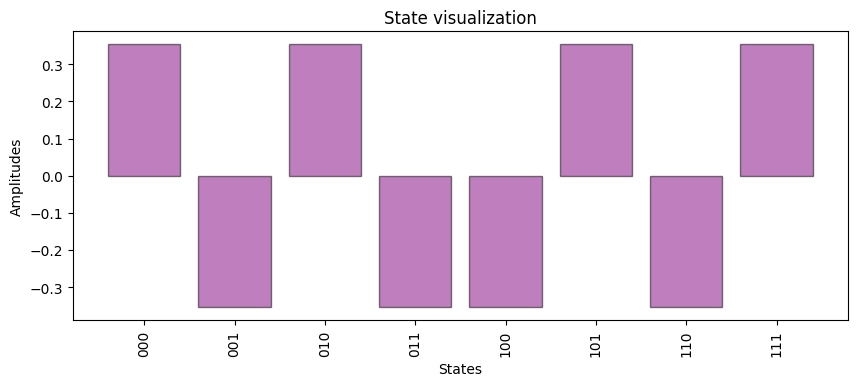

In [14]:
# collect state object and visualize state through plot_input_register_amplitudes
outcome = c()

plot_input_register_amplitudes(outcome.state())

As we can see from the plot, the flipped amplitudes correspond to the ones in which the control qubits are in the state $|1\rangle$

#### Combining all layers into the DJ algorithm

Finally, we can combine all the layers and verify the effectiveness of the DJ algorithm. We expect to get $|0\rangle^{\otimes N}$ if the oracle is constant and, on the other side, probability zero of getting $|0\rangle^{\otimes N}$ if the oracle corresponds to a balanced function.

#### DJ and constant oracle

In [19]:
# full algorithm with constant oracle: initial layer + constant oracle + final layer
c = build_initial_layer(n=nqubits) + build_constant_oracle(n=nqubits) + build_final_layer(n=nqubits)

In [20]:
# draw the circuit
print(c.draw())

q0: ─H─H─M─
q1: ─H─H─M─
q2: ─H─H─M─
q3: ─X─H───


In [21]:
# collect outcome object
outcome = c()

# print state
print(outcome)

(0.70711+0j)|0000> + (-0.70711+0j)|0001>


And what about the final amplitudes of the input register?

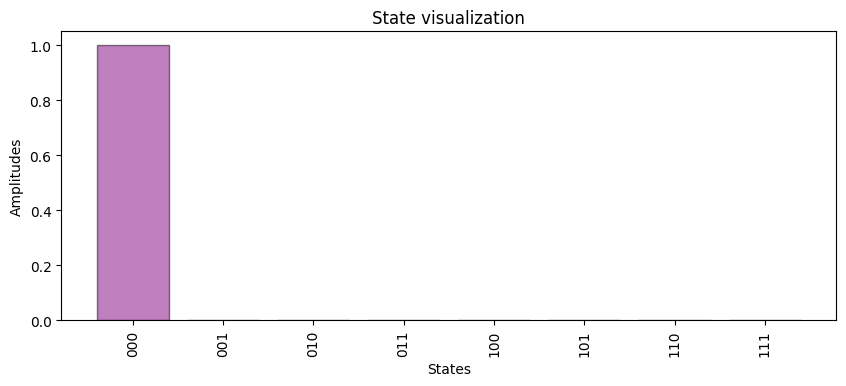

In [22]:
# plot the state via plot_input_register_amplitudes
plot_input_register_amplitudes(outcome.state())

#### DJ and balanced oracle

In [23]:
# full algorithm with constant oracle: initial layer + balanced oracle + final layer
c = build_initial_layer(n=nqubits) + build_balanced_oracle("100") + build_final_layer(n=nqubits)

In [24]:
# draw the circuit
print(c.draw())

q0: ─H───o─H─M─
q1: ─H───|─H─M─
q2: ─H───|─H─M─
q3: ─X─H─X─────


In [25]:
# collect outcome object
outcome = c()

# print state
print(outcome)

(0.70711+0j)|1000> + (-0.70711+0j)|1001>


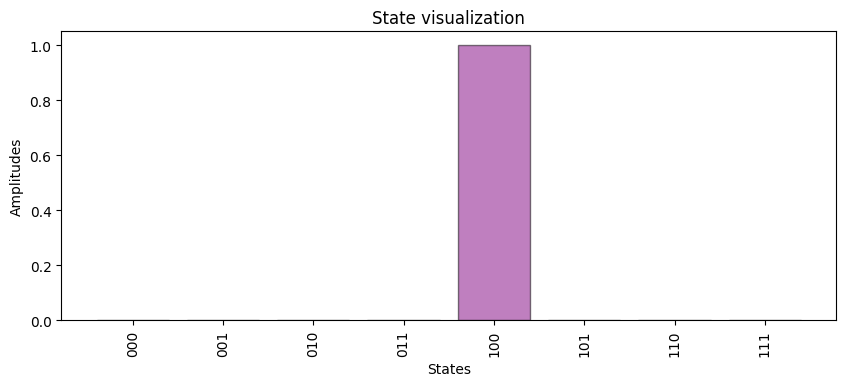

In [26]:
# plot the state via plot_input_register_amplitudes
plot_input_register_amplitudes(outcome.state())

#### But wait, what does black box means?

We often speak of the oracles as black boxes: something you are not expected to look into. In this lecture, on contrary, we built our own oracles, perfectly knowing what we have inside. 

This is true! Because we really wanted to understand what a balanced and a constant oracle are. But once this is done, we can finally use the DJ algorithm with is pure power. Thanks to DJ you are able to understand if the function encoded into an oracle is balanced or constant **without** looking into the oracle and, moreover, with just one algorithm evaluation. 

Let's make a simple exercise!

<div style="background-color: rgba(255, 105, 105, 0.3); border: 2.5px solid #000000; padding: 15px;">
<strong>Exercise:</strong> import the <code>scripts.utils.black_box_oracle</code> function. It will return a simple oracle function. It accepts one argument `n`, exactly like the functions you already used during this lecture. Let's build a DJ circuit around this black box oracle and execute it. Can you understand if the encoded function is balanced or constant? Finally, open the black box and check with your eyes.
</div>